In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from common import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def wjaccard_on_dist(a, b):
    mn = np.sum(np.minimum(a[:,0], b[:,0]))
    mx = np.sum(np.maximum(a[:,0], b[:,0]))
    return mn/mx


def l1_on_dist(a, b):
    return np.sum(np.abs(a[:, 0] - b[:, 0]))


def attach_new_metric(df):
#     new_metric = compute_metric(df, wjaccard_on_dist)
#     df['wjaccard_dist_ksim'] = new_metric[:,0]
#     df['wjaccard_dist_paa'] = new_metric[:,1]
    new_metric = compute_metric(df, l1_on_dist)
    df['l1_ksim'] = new_metric[:,0]
    df['l1_paa'] = new_metric[:,1]
    return df


prefix='../../results'

all_datasets = {}
for d in all_dataset_metadata:
    df_in = attach_new_metric(read_results_file('%s/ksim_%s_0.1_results.txt' % (prefix, d['file_name'])))
    df_out = attach_new_metric(read_results_file('%s/ksim_outside_%s_0.1_results.txt' % (prefix, d['file_name'])))
    df_out['ts_index'] += 10000
    all_datasets[d['file_name']] = {
        'df': combine_in_out(df_in, df_out),
        'name': d['name'],
        'size': d['size']
    }

# Running time

In [306]:
def time_best_match(df, metric, k):
    dfk = df[df.k == k]
    examples = dfk[['ts_index', 'ts_start', 'ts_end']].drop_duplicates()
    metric_col = metric + '_ksim'
    counter = 0
    time_ksim, time_bf, time_paa = [], [], []
    for index, row in examples.iterrows():
        counter += 1
        selector = ((dfk['ts_index'] == row['ts_index']) 
                    & (dfk['ts_start'] == row['ts_start'])
                    & (dfk['ts_end'] == row['ts_end']))
        current = dfk[selector][[metric_col, 'time_ksim', 'time_bf', 'time_paa']]
        idxmax = current[metric_col].idxmax()
        time_ksim.append(current['time_ksim'][idxmax])
        time_bf.append(current['time_bf'][idxmax])
        time_paa.append(current['time_paa'][idxmax])
    
    return np.array(time_ksim), np.array(time_bf), np.array(time_paa)

ksim is faster than bf 1874.17879314 times
paa is faster than bf 690.280310923 times


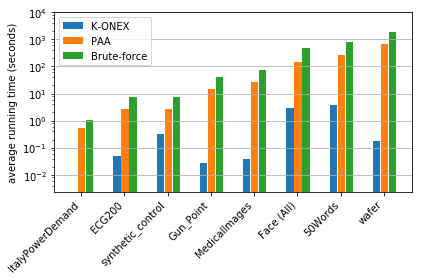

In [307]:
all_time = []
for i, (key, d) in enumerate(all_datasets.items()):
    ksim, bf, paa = time_best_match(d['df'], 'l1', 1)
    all_time.append({
        'ksim_mean': ksim.mean(),
        'ksim_std': ksim.std(),
        'bf_mean': bf.mean(),
        'bf_std': bf.std(),
        'paa_mean': paa.mean(),
        'paa_std': paa.std(),
        'name': d['name'],
        'size': d['size']
    })

all_time_df = pd.DataFrame(all_time).sort_values(by='size')

f, ax = plt.subplots(1)

barwidth = 0.5
padding = 0.05
x = 3.0*np.arange(0, all_time_df.shape[0])

error_config = {'capsize': 2, 'capthick': 1}

ax.bar(x, all_time_df['ksim_mean'], barwidth, label='K-ONEX')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)
ax.bar(x + barwidth+padding, all_time_df['paa_mean'], barwidth, label='PAA')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)
ax.bar(x + 2*(barwidth+padding), all_time_df['bf_mean'], barwidth, label='Brute-force')
#        yerr=time_ksim[:, 1],
#        error_kw=error_config)

print 'ksim is faster than bf', (all_time_df.bf_mean / all_time_df.ksim_mean).mean(), 'times'
print 'paa is faster than bf', (all_time_df.paa_mean / all_time_df.ksim_mean).mean(), 'times'

ax.yaxis.grid('on')
ax.set_yscale('log')
ax.set_ylabel('average running time (seconds)')
ax.set_ylim(0, 10000)
ax.set_xticks(x + barwidth)
ax.set_xticklabels(all_dataset_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig('time_comparison.eps')

# Explored percentage

In [300]:
def min_explored_percentage(df, metric, k):
    dfk = df[df.k == k]
    examples = dfk[['ts_index', 'ts_start', 'ts_end']].drop_duplicates()

    h = []
    extra = []
    metric_col = metric + '_ksim'    
    for index, row in examples.iterrows():
        selector = ((dfk['ts_index'] == row['ts_index']) 
                    & (dfk['ts_start'] == row['ts_start'])
                    & (dfk['ts_end'] == row['ts_end']))
        current = dfk[selector][[metric_col, 'h', 'h_extra']].drop_duplicates()
        
        idxmin = current[metric_col].idxmin()
        h.append(current.h[idxmin])
        extra.append(current.h_extra[idxmin] - current.h[idxmin])

    return np.array(h), np.array(extra)


def avg_min_ke_all_datasets(k):
    avg_min_ke = []
    for i, (key, d) in enumerate(all_datasets.items()):
        h, e = min_explored_percentage(d['df'], 'l1', k)
        avg_min_ke.append({
            'h_mean': h.mean() / d['size'] * 100,
            'h_std': h.std() / d['size'] * 100,
            'e_mean': e.mean() / d['size'] * 100,
            'e_std': e.std() / d['size'] * 100,
            'size': d['size'],
            'name': d['name']
        })

    return pd.DataFrame(avg_min_ke)


def plot_percentage(ax, percent, std, names, yscale='linear', ylabel=''):
    bar_width = 1
    
    # positions of the left bar-boundaries
    bar_l = [i for i in range(len(df.h_mean))] 
    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l] 

    rest = 100 - percent
    
    # Plot h_mean
    ax.bar(bar_l, percent
           , label='$k_e$'
           , yerr=std
           , error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1)
           , color='#4c92c3', width=bar_width, edgecolor='white', linewidth=0.5)

    # Plot the rest to fill 100%
    ax.bar(bar_l, rest
           , bottom=percent, label='unexplored'
           , color='#e8e8e8', width=bar_width, edgecolor='white', linewidth=0.5)

    ax.set_xticks(tick_pos)
    ax.set_xticklabels(names, rotation=45, ha='right')
    
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    
    ax.set_yscale(yscale)

    ax.set_xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
    ax.set_ylim(0, 110)

    
def plot_percentage_and_extra_by_k(k):
    df_avg_min_ke = avg_min_ke_all_datasets(k)
    df_avg_min_ke = df_avg_min_ke.sort_values(by='size')

    print df_avg_min_ke
    
    ## Plot k_e
    f, ax = plt.subplots(1)

    # Plot the linear scale version
    plot_percentage(ax, df_avg_min_ke['h_mean'], df_avg_min_ke['h_std']
                    , names=df_avg_min_ke['name']
                    , ylabel='explored percentage of sequences (%)')
    # Create and plot the log scale version in an inset axes
    axins = zoomed_inset_axes(ax, 0.5, loc=1)
    plot_percentage(axins, df_avg_min_ke['h_mean'], df_avg_min_ke['h_std']
                    , names=df_avg_min_ke['name']
                    , yscale="log")

    plt.tight_layout()
    plt.savefig('explored_percentage_k%d.eps'%k)
    
    ## Plot extra
    f, ax = plt.subplots(1)
    
    # Plot the linear scale version
    plot_percentage(ax, df_avg_min_ke['e_mean'], df_avg_min_ke['e_std']
                    , names=df_avg_min_ke['name']
                    , ylabel='extra explored percentage of dataset (%)')
    # Create and plot the log scale version in an inset axes
    axins = zoomed_inset_axes(ax, 0.5, loc=1)
    plot_percentage(axins, df_avg_min_ke['e_mean'], df_avg_min_ke['e_std']
                    , names=df_avg_min_ke['name']
                    , yscale="log")
    
#     df_avg_extra.plot(kind='bar', y='e_mean', yerr='e_std'
#                       , color='#4c92c3'
#                       , ylim=(0, 0.6)
#                       , ax=ax
#                       , legend=False
#                       , error_kw=dict(ecolor='red', lw=1, capsize=5, capthick=1))
#     ax.set_ylabel('extra explored percentage (%)')
#     ax.set_xticklabels(df_avg_extra['name'], rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('extra_explored_k%d.eps'%k)


## K = 1

     e_mean     e_std    h_mean     h_std               name      size
5  0.214483  0.295564  0.938206  1.431739   ItalyPowerDemand     30084
7  0.009433  0.014048  0.099178  0.144637                ECG    456000
6  0.000188  0.000000  0.000188  0.000000  synthetic_control    531000
4  0.005397  0.011023  0.074581  0.105044          Gun-Point   1676250
0  0.019653  0.041595  0.234315  0.423402      MedicalImages   3686760
2  0.000084  0.000090  0.015007  0.017748         Face (All)  14390350
3  0.001461  0.002908  0.043997  0.051409            50Words  16523325
1  0.007128  0.008310  0.107497  0.130221              Wafer  70852824


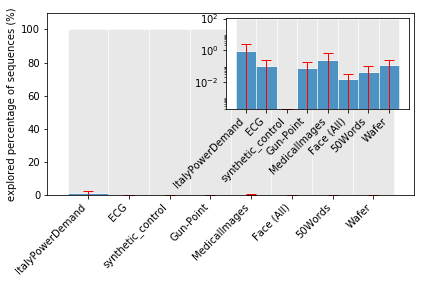

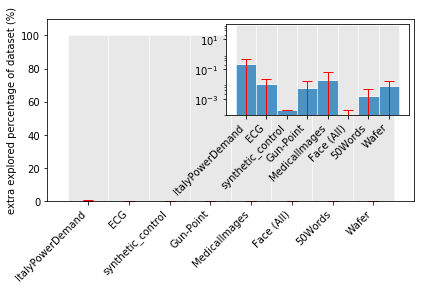

In [301]:
plot_percentage_and_extra_by_k(1)

## K = 9

     e_mean     e_std    h_mean     h_std               name      size
5  0.230771  0.295670  2.352579  2.489412   ItalyPowerDemand     30084
7  0.007725  0.009949  0.203728  0.209410                ECG    456000
6  0.000188  0.000000  0.001695  0.000000  synthetic_control    531000
4  0.004644  0.009681  0.132045  0.150460          Gun-Point   1676250
0  0.016194  0.030990  0.334884  0.507298      MedicalImages   3686760
2  0.000243  0.000510  0.060561  0.090301         Face (All)  14390350
3  0.001401  0.002901  0.060042  0.059988            50Words  16523325
1  0.006579  0.008945  0.203505  0.188069              Wafer  70852824


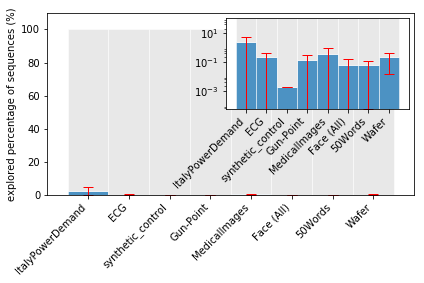

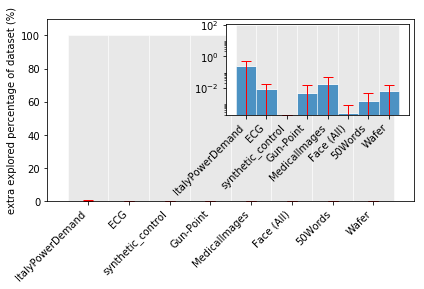

In [302]:
plot_percentage_and_extra_by_k(9)

## K = 15

     e_mean     e_std    h_mean     h_std               name      size
5  0.200522  0.238574  3.037329  2.821261   ItalyPowerDemand     30084
7  0.008512  0.011810  0.229989  0.225033                ECG    456000
6  0.000188  0.000000  0.002825  0.000000  synthetic_control    531000
4  0.004751  0.009695  0.144358  0.160310          Gun-Point   1676250
0  0.016933  0.035550  0.387022  0.565933      MedicalImages   3686760
2  0.001252  0.004677  0.067603  0.104395         Face (All)  14390350
3  0.001469  0.002933  0.068577  0.067312            50Words  16523325
1  0.005671  0.007438  0.242512  0.203582              Wafer  70852824


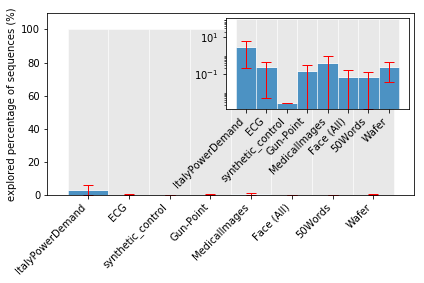

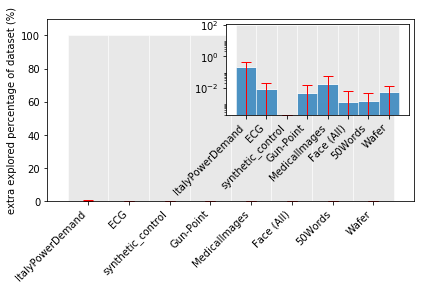

In [303]:
plot_percentage_and_extra_by_k(15)